In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
import nd2
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models
# from cellpose.io import imread
import cellpose
from cellpose.io import imread

In [2]:
"""
Run only once.
Generating maximum intensity projections for each field of view for each nd2 file in directory. Helpful references:
https://stackoverflow.com/questions/48178916/maximum-intensity-projection-from-image-stack
https://gist.github.com/ax3l/5781ce80b19d7df3f549
"""

# # from PIL import Image
# import tifffile
# import numpy as np


# # max_projections = []
# for img_ind in range(len(image_arrays)): #image_array in image_arrays:
#     image_array = image_arrays[img_ind]
#     filename = filenames[img_ind]
#     for fov_ind in range(len(image_array)):
#         fov = image_array[fov_ind]
#         print(type(fov))
#         temp = []
#         for i in range(3):
#             channel = fov[:,i,:,:]
#             print(i,channel.shape)
#             fov_channel_max = np.max(channel, axis=0)
#             temp.append(fov_channel_max)
# #         max_projections.append(temp)
#         tifffile.imwrite('./Projections/'+filename+'fov_'+str(fov_ind+1)+'.tif', 
#                          temp, photometric='minisblack')

'\nRun only once.\nGenerating maximum intensity projections for each field of view for each nd2 file in directory. Helpful references:\nhttps://stackoverflow.com/questions/48178916/maximum-intensity-projection-from-image-stack\nhttps://gist.github.com/ax3l/5781ce80b19d7df3f549\n'

In [2]:
"""
function that will import images and masks
"""

def import_data(proj_directory_str, masks_directory_str):

    X = []
    masks = []
    filenames = []
    
    directory = os.fsencode(proj_directory_str)
    for file in [file for file in sorted(os.listdir(directory)) if os.fsdecode(file)[-4:] == '.tif']:
        filename = os.fsdecode(file)
        filenames.append(filename)

        mask_filename = filename[:-4] + '_MASK' + '.tif'

        image_array = imread(proj_directory_str+filename)
        mask_array = imread(masks_directory_str+mask_filename)

        X.append(image_array)
        masks.append(mask_array)
    
    return X, masks, filenames
    
    
# importing images and masks
    
    
train_proj_directory_str = './Train Projections/'
train_masks_directory_str = './Train Masks/'
test_proj_directory_str = './Test Projections/'
test_masks_directory_str = './Test Masks/'
    
train_imgs, train_masks, train_filenames = import_data(train_proj_directory_str, train_masks_directory_str)
test_imgs, test_masks, test_filenames = import_data(test_proj_directory_str, test_masks_directory_str)

In [3]:
import skimage.feature
import scipy.signal
import scipy.ndimage

def get_hog_for_pixel(normalized_blocks, i, j, pixels_per_cell=(8,8), cells_per_block=(3,3), 
                      img_shape=(2048,2048)):
    """
    Returns a list of up to 9 9-dimensional orientation-gradient vectors. Each vector will correspond to the same
    cell (i.e., the one which the pixel at (i,j) belongs to) but will be normalized according to its block (blocks
    are overlapping).
    
    As of now, I don't actually use this function.
    
    """
    
    rows_pc, cols_pc = pixels_per_cell
    
    # first we identify which cell our pixel belongs to (i.e., r and c coordinates for normalized_blocks in source)
    if (i >= img_shape[0] or j>=img_shape[1] or i < 0 or j < 0):
        raise ValueError("(i,j) not in valid range.)")
    cell_row = i//rows_pc
    cell_col = j//cols_pc
    
    # now we identify which blocks in normalized_blocks contain this cell (and where in the block the cell is)
    cell_rows_pb, cell_cols_pb = cells_per_block
    orientation_vectors = []

    for r_0 in range(cell_row-(cell_rows_pb-1), cell_row+1):
        if r_0<0 or r_0>=len(normalized_blocks):
#             for i in range(3):
#                 orientation_vectors.append([None,None,None,None,None,None,None,None,None])
            continue
        row_of_block = cell_row-r_0
        for c_0 in range(cell_col-(cell_cols_pb-1), cell_col+1):
            if c_0<0 or c_0>=len(normalized_blocks[0]):
#                 orientation_vectors.append([None,None,None,None,None,None,None,None,None])
                continue
            col_of_block = cell_col-c_0
            vector = normalized_blocks[r_0, c_0, row_of_block, col_of_block]
            orientation_vectors.append(vector)
    return np.mean(np.array(orientation_vectors), axis=0)


    
            
    
def get_X_for_img(feature_stack):
    X_img = []
    for i in range(len(feature_stack)):
        for j in range(len(img[0])):
            result = []
            for value in feature_stack[i][j]:
                result.append(value)     
            
            X_img.append(result)
            
    return np.array(X_img)

def get_X(feature_stack_list):
    X = []
    for feature_stack in feature_stack_list:
        X_img = get_X_for_img(feature_stack)
        X.append(X_img)
    
    return np.array(X) 

def get_y_for_img(img, original_masks):
    result = []
    for i in range(len(img)):
        for j in range(len(img[0])):
            if original_masks[i,j] > 0:
                result.append(1)
            else:
                result.append(0)
    return result

def get_y(imgs, masks_array):
    if not len(imgs) == len(masks_array):
        print('Number of images and masks are not equal!')
    else:
        y = []
        for i in range(len(imgs)):
            img = imgs[i]
            mask = masks_array[i]
            y_img = get_y_for_img(img, mask)
            y.append(y_img)
        return np.array(y)
    
    
                
"""
Preparing training and validation data. Need to clean up below.
"""

def normalize_image(img):
    for i in range(len(img)):
        for j in range(len(img[0])):
    #         print(img[i][j])
    #         print(img[i][j]/65)
            img[i][j] = img[i][j]/65535
    return img





img = normalize_image(train_imgs[0][0].copy())
img_2 = normalize_image(test_imgs[0][0].copy())
img_3 = normalize_image(train_imgs[2][0].copy())

img_test = normalize_image(train_imgs[1][0].copy())

    

"""
Replacing this block of code with features learned in Python

features_train = np.array(imread('./Feature Stacks/feature-stack0001.tif'))
features_train_2 = np.array(imread('./Feature Stacks/feature-stack0001_2.tif'))
features_train_3 = np.array(imread('./Feature Stacks/feature-stack0001_3.tif'))
features_test = np.array(imread('./Feature Stacks/feature-stack0001_test.tif'))
"""

features_train = skimage.feature.multiscale_basic_features(img)
features_train_2 = skimage.feature.multiscale_basic_features(img_2)
features_train_3 = skimage.feature.multiscale_basic_features(img_3)
features_test = skimage.feature.multiscale_basic_features(img_test)

print(features_train.shape)


X_train = get_X_for_img(features_train)
X_train_temp = get_X_for_img(features_train_2)
X_train = np.concatenate((X_train, X_train_temp))
X_train_temp = get_X_for_img(features_train_3)
X_train = np.concatenate((X_train, X_train_temp))
X_test = get_X_for_img(features_test)

y_train = get_y_for_img(img, train_masks[0])
y_train_temp = get_y_for_img(img_2, test_masks[0])
y_train = np.concatenate((y_train, y_train_temp))
y_train_temp = get_y_for_img(img_3, train_masks[2])
y_train = np.concatenate((y_train, y_train_temp))
y_test = get_y_for_img(img_test, train_masks[1])

(2048, 2048, 24)


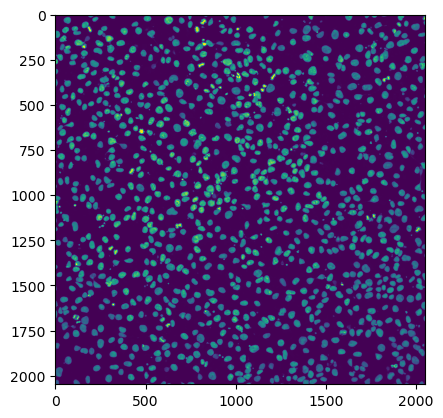

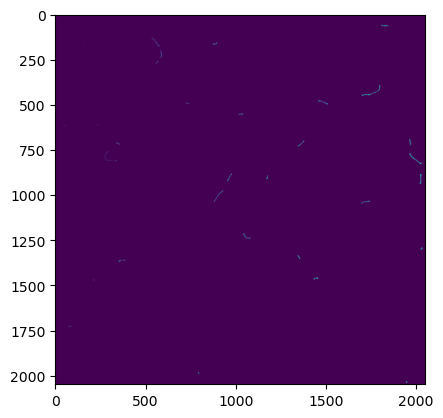

In [9]:
"""
Image and mask for demonstration purposes
"""

plt.imshow(features_train[2])
plt.imshow(train_imgs[2][0])
plt.show()
plt.imshow(train_masks[2])

In [4]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [12]:
scale_pos_weight = len([val for val in list(y_train.flatten()) if val == 0])/\
    len([val for val in list(y_train.flatten()) if val > 0])

print(scale_pos_weight)

1260.1919414653703


In [13]:
"""
Train the XGBoost model
"""

import xgboost as xgb

params = {
    'colsample_bynode': 0.7,
    'learning_rate': .3,
    'max_depth': 5,
    'num_parallel_tree': 25,
    'objective': 'binary:logistic',
    'subsample': 0.7,
    'tree_method': 'hist',
    'scale_pos_weight': 35
  
}

bst = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=True)

[0]	train-logloss:0.44263	test-logloss:0.44093
[1]	train-logloss:0.30375	test-logloss:0.30128
[2]	train-logloss:0.21604	test-logloss:0.21314
[3]	train-logloss:0.15728	test-logloss:0.15411
[4]	train-logloss:0.11654	test-logloss:0.11323
[5]	train-logloss:0.08770	test-logloss:0.08428
[6]	train-logloss:0.06697	test-logloss:0.06348
[7]	train-logloss:0.05192	test-logloss:0.04842
[8]	train-logloss:0.04094	test-logloss:0.03743
[9]	train-logloss:0.03289	test-logloss:0.02933
[10]	train-logloss:0.02698	test-logloss:0.02335
[11]	train-logloss:0.02258	test-logloss:0.01895
[12]	train-logloss:0.01932	test-logloss:0.01569
[13]	train-logloss:0.01686	test-logloss:0.01326
[14]	train-logloss:0.01502	test-logloss:0.01146
[15]	train-logloss:0.01364	test-logloss:0.01010
[16]	train-logloss:0.01260	test-logloss:0.00909
[17]	train-logloss:0.01179	test-logloss:0.00831
[18]	train-logloss:0.01117	test-logloss:0.00773
[19]	train-logloss:0.01071	test-logloss:0.00730
[20]	train-logloss:0.01032	test-logloss:0.00694
[2

[170]	train-logloss:0.00376	test-logloss:0.00347
[171]	train-logloss:0.00374	test-logloss:0.00346
[172]	train-logloss:0.00373	test-logloss:0.00346
[173]	train-logloss:0.00371	test-logloss:0.00345
[174]	train-logloss:0.00369	test-logloss:0.00344
[175]	train-logloss:0.00367	test-logloss:0.00343
[176]	train-logloss:0.00366	test-logloss:0.00343
[177]	train-logloss:0.00364	test-logloss:0.00342
[178]	train-logloss:0.00363	test-logloss:0.00341
[179]	train-logloss:0.00361	test-logloss:0.00341
[180]	train-logloss:0.00359	test-logloss:0.00340
[181]	train-logloss:0.00358	test-logloss:0.00340
[182]	train-logloss:0.00356	test-logloss:0.00339
[183]	train-logloss:0.00354	test-logloss:0.00338
[184]	train-logloss:0.00353	test-logloss:0.00337
[185]	train-logloss:0.00351	test-logloss:0.00337
[186]	train-logloss:0.00350	test-logloss:0.00336
[187]	train-logloss:0.00348	test-logloss:0.00335
[188]	train-logloss:0.00347	test-logloss:0.00335
[189]	train-logloss:0.00345	test-logloss:0.00334
[190]	train-logloss:

[338]	train-logloss:0.00197	test-logloss:0.00286
[339]	train-logloss:0.00197	test-logloss:0.00286
[340]	train-logloss:0.00196	test-logloss:0.00285
[341]	train-logloss:0.00195	test-logloss:0.00285
[342]	train-logloss:0.00195	test-logloss:0.00285
[343]	train-logloss:0.00194	test-logloss:0.00285
[344]	train-logloss:0.00193	test-logloss:0.00285
[345]	train-logloss:0.00193	test-logloss:0.00285
[346]	train-logloss:0.00192	test-logloss:0.00285
[347]	train-logloss:0.00191	test-logloss:0.00285
[348]	train-logloss:0.00191	test-logloss:0.00284
[349]	train-logloss:0.00190	test-logloss:0.00284
[350]	train-logloss:0.00190	test-logloss:0.00284
[351]	train-logloss:0.00189	test-logloss:0.00284
[352]	train-logloss:0.00188	test-logloss:0.00284
[353]	train-logloss:0.00188	test-logloss:0.00284
[354]	train-logloss:0.00187	test-logloss:0.00284
[355]	train-logloss:0.00186	test-logloss:0.00284
[356]	train-logloss:0.00186	test-logloss:0.00284
[357]	train-logloss:0.00185	test-logloss:0.00284
[358]	train-logloss:

In [14]:
bst.save_model("./Models/model5.json")

In [5]:
"""
If we're loading a saved model
"""

bst = xgb.Booster()
bst.load_model('./Models/model3.json')

In [ ]:
"""
Experimenting with an SVM; still need to do
"""
# from sklearn import svm


# clf = svm.SVC()
# clf.fit(X_train, y_train)
# SVC()

In [15]:
import sklearn.metrics

y_pred = bst.predict(data=dtrain)
y_pred = np.reshape(np.array(y_pred), (2048, 2048))
# plt.imshow(y_pred)



# accuracy_score()

ValueError: cannot reshape array of size 12582912 into shape (2048,2048)

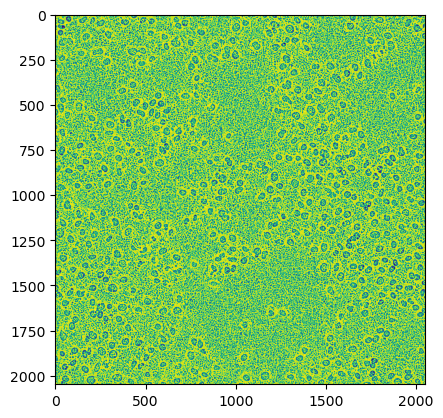

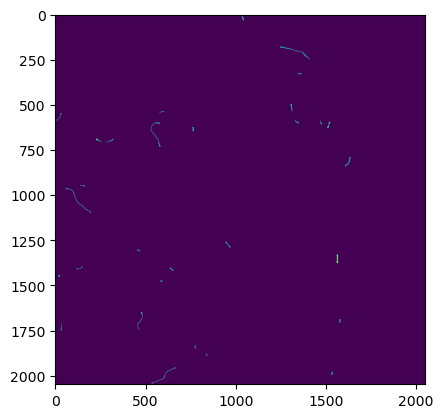

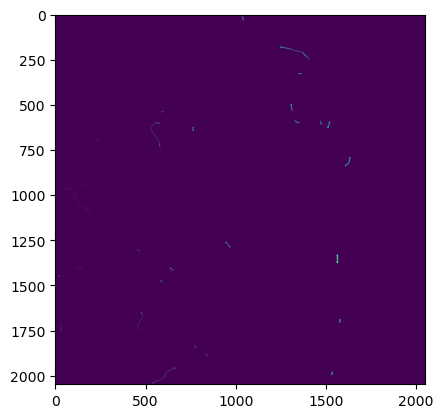

In [6]:
y_pred_2 = bst.predict(data=dtest)
# y_pred_2 = [0 if val<threshold else 1 for val in y_pred_2]
y_pred_2 = np.reshape(np.array(y_pred_2), (2048, 2048))
plt.imshow(y_pred_2)
plt.show()
plt.imshow(np.reshape(np.array(y_test), (2048,2048)))
plt.show()
plt.imshow(train_masks[1])

In [25]:
y_pred_2 = skimage.filters.median(y_pred_2)
plt.imshow(y_pred_2)

RuntimeError: filter footprint array has incorrect shape.

In [17]:
import sklearn.metrics

"""
Calculating IOU performance at different threshold values.
First impression is that that the best threshold to use is 0.65 for test data.
"""

def custom_round(num, threshold):
    if num > threshold:
        return 1
    else:
        return 0
    
# y_pred = y_pred.flatten()
y_pred_2 = y_pred_2.flatten()
    
for thresh_scaled in range(0,100,5):
    thresh = float(thresh_scaled)/100
#     y_pred = y_pred.flatten()
#     y_pred_bin = [custom_round(pixel, thresh) for pixel in y_pred]
#     iou_tr = sklearn.metrics.jaccard_score(y_train, y_pred_bin)
#     print(iou,',')

#     y_pred_2 = y_pred_2.flatten()
    y_pred_2_bin = [custom_round(pixel, thresh) for pixel in y_pred_2]
    iou_te = sklearn.metrics.jaccard_score(y_test, y_pred_2_bin)
    print(thresh, ', ', iou_te)

0.0 ,  0.0009009838104248047
0.05 ,  0.2922014780241151
0.1 ,  0.33937298843723923
0.15 ,  0.366693354683747
0.2 ,  0.382487818859272
0.25 ,  0.3955393718707328
0.3 ,  0.4041237113402062
0.35 ,  0.4119294776734223
0.4 ,  0.417490623934538
0.45 ,  0.4197163368937139
0.5 ,  0.4209578682030969
0.55 ,  0.422172866925782
0.6 ,  0.42367719832508566
0.65 ,  0.42565712043938797
0.7 ,  0.4227053140096618
0.75 ,  0.41658031088082903
0.8 ,  0.40683030949839916
0.85 ,  0.3897819863466197
0.9 ,  0.3664226898444648
0.95 ,  0.31292026897214215


{'f0': 8390.0, 'f1': 11509.0, 'f2': 9940.0, 'f3': 13344.0, 'f4': 5847.0, 'f5': 9190.0, 'f6': 9057.0, 'f7': 12605.0, 'f8': 7562.0, 'f9': 12442.0, 'f10': 13163.0, 'f11': 15597.0, 'f12': 10648.0, 'f13': 14789.0, 'f14': 16240.0, 'f15': 14924.0, 'f16': 12478.0, 'f17': 15855.0, 'f18': 17711.0, 'f19': 16908.0, 'f20': 22146.0, 'f21': 22627.0, 'f22': 24206.0, 'f23': 21455.0}
[('f4', 5847.0), ('f8', 7562.0), ('f0', 8390.0), ('f6', 9057.0), ('f5', 9190.0), ('f2', 9940.0), ('f12', 10648.0), ('f1', 11509.0), ('f9', 12442.0), ('f16', 12478.0), ('f7', 12605.0), ('f10', 13163.0), ('f3', 13344.0), ('f13', 14789.0), ('f15', 14924.0), ('f11', 15597.0), ('f17', 15855.0), ('f14', 16240.0), ('f19', 16908.0), ('f18', 17711.0), ('f23', 21455.0), ('f20', 22146.0), ('f21', 22627.0), ('f22', 24206.0)]


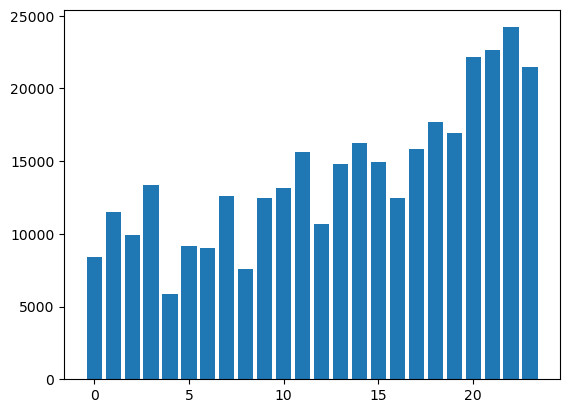

In [18]:
from collections import OrderedDict

"""
In order to increase the number of images we can train over, we may decide to reduce the number of features we use 
in the future. Below is a visual demonstration of feature importances in the XGBoost model.
"""

# plot feature importance
# print(sorted([bst.get_fscore()[name] for name in list((bst.get_fscore()))]))
print((bst.get_fscore()))
dict = bst.get_fscore()

list_of_tuples = (list(dict.items()))
list_of_tuples.sort(key = lambda x: x[1])

print(list_of_tuples)




plt.bar(range(len(bst.get_fscore())), bst.get_fscore().values())
plt.show()

In [19]:
bst.get_score(importance_type='gain')

{'f0': 675.4986572265625,
 'f1': 93.61717987060547,
 'f2': 60.09650421142578,
 'f3': 289.42724609375,
 'f4': 183.84339904785156,
 'f5': 67.55345916748047,
 'f6': 135.08197021484375,
 'f7': 636.3392944335938,
 'f8': 93.42389678955078,
 'f9': 171.05772399902344,
 'f10': 184.3536376953125,
 'f11': 405.4535217285156,
 'f12': 653.6590576171875,
 'f13': 238.07003784179688,
 'f14': 193.7237548828125,
 'f15': 153.71900939941406,
 'f16': 1415.858642578125,
 'f17': 79.97467803955078,
 'f18': 196.5221405029297,
 'f19': 166.3915252685547,
 'f20': 81.46141815185547,
 'f21': 68.91143035888672,
 'f22': 128.5841064453125,
 'f23': 120.86865234375}

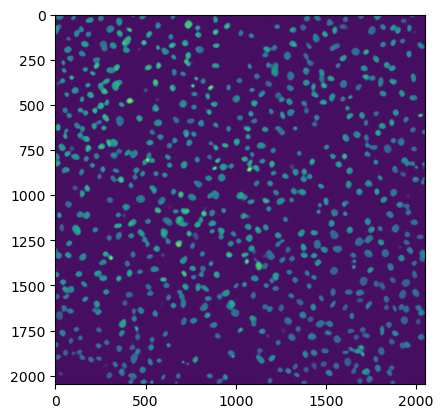

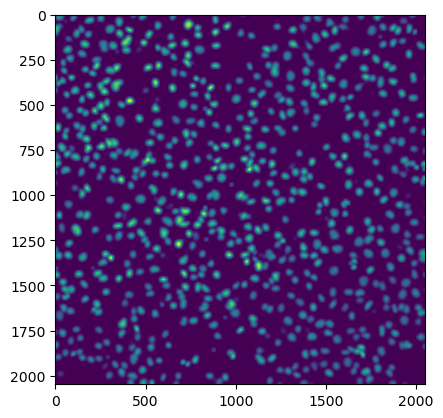

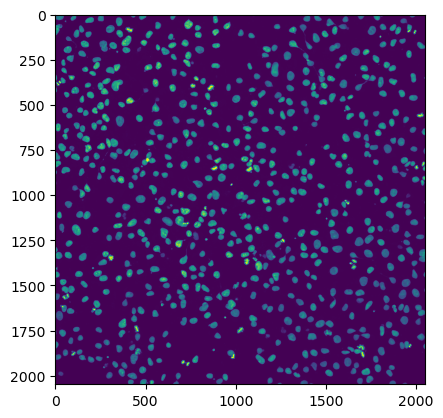

In [41]:
import scipy.ndimage

"""
May use these filters for post processing in the future
"""

medians = scipy.signal.medfilt2d(input=img, kernel_size=21)
means = scipy.ndimage.uniform_filter(input=img, size=21)
plt.imshow(medians)
plt.show()
plt.imshow(means)
plt.show()
plt.imshow(img)